In [1]:
from lxml import etree
import numpy as np
import random
from tqdm import tqdm
import glob

from tiatoolbox.wsicore.wsireader import WSIReader
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.affinity import scale
from shapely.geometry import Polygon, box, mapping

import numpy as np
from PIL import Image


import argparse
import glob
import os
import openslide
import h5py
import cv2
from shapely.geometry import box, Polygon


In [2]:
def validate_and_correct_polygon(polygon):
    if not polygon.is_valid:
        corrected_polygon = polygon.buffer(0)
        if corrected_polygon.is_valid:
            return corrected_polygon
        else:
            # Further correction attempts or logging for manual review
            # For complex cases, consider using simplify() with a small tolerance
            simplified_polygon = polygon.simplify(1.0, preserve_topology=True)
            if simplified_polygon.is_valid:
                return simplified_polygon
            else:
                raise ValueError("Polygon could not be corrected and remains invalid.")
    return polygon

def xml_to_polygons(xml_path):
    tree = etree.parse(xml_path)
    annotations = []
    for annotation in tree.xpath('.//Annotation'):
        points = []
        for coordinate in annotation.xpath('.//Coordinate'):
            x = float(coordinate.get('X'))
            y = float(coordinate.get('Y'))
            points.append([x, y])
        annotations.append(points)
    
    polygons = []
    for annotation in annotations:
        if len(annotation)>3:
            polygon = Polygon(annotation)
            corrected_polygon = validate_and_correct_polygon(polygon)
            polygons.append(corrected_polygon)

    return polygons

In [3]:
def polygons_to_patches(polygons, slide_dimension, patch_level, overlap = 0.1):    
    step_size = int(slide_dimension * (1 - overlap))*(2**patch_level)
    patch_area = slide_dimension ** 2  
    patches_info = []
    for target_polygon in polygons:
        min_x, min_y, max_x, max_y = map(int, target_polygon.bounds)
        for x_start in np.arange(min_x, max_x - slide_dimension + 1, step_size):
            for y_start in np.arange(min_y, max_y - slide_dimension + 1, step_size):
                x_end = int(x_start) + slide_dimension
                y_end = int(y_start) + slide_dimension

                # Create a shapely Polygon object for the current patch
                patch_polygon = box(x_start, y_start, x_end, y_end)

                # Calculate the intersection of the patch with the target polygon
                intersection = target_polygon.intersection(patch_polygon)

                # Calculate the percentage of the patch that lies within the target polygon
                percentage_inside = (intersection.area / patch_area) * 100

                patches_info.append({
                    'coordinates': (x_start, y_start),
                    'percentage_inside': percentage_inside,
                    'target_polygon': target_polygon,
                    'intersection':intersection
                })
    return patches_info

In [4]:
def process_normal_patches(patch_path, output_class):
    class_name = patch_path.split(os.sep)[-3]
    file_name = os.path.basename(patch_path)
    patch_name = os.path.splitext(file_name)[0]
    

    raw_patch_path = os.path.join(args.raw_data_folder, class_name, f"{patch_name}.{args.wsi_extension}")
    wsi = openslide.open_slide(raw_patch_path)
    os.makedirs(os.path.join(args.output_folder, output_class), exist_ok=True)
    with h5py.File(patch_path, 'r') as hdf5_file:
        patch_level = hdf5_file['coords'].attrs['patch_level']
        patch_size = hdf5_file['coords'].attrs['patch_size']
        for idx in range(len(hdf5_file['coords'])):
            coord = hdf5_file['coords'][idx]
            if os.path.isfile(os.path.join(args.output_folder, class_name, f"{patch_name}_{idx}.jpg")):
                continue
            img = wsi.read_region(coord, patch_level, (patch_size, patch_size)).convert('RGB')
            img = np.array(img)
            cv2.imwrite(os.path.join(args.output_folder, output_class, f"{patch_name}_{idx}.jpg"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [408]:
def get_mask(intersection, start_x, start_y, image_size):
    mask_image = Image.new('L', (image_size, image_size), 0)

    # Prepare to draw on the image
    draw = ImageDraw.Draw(mask_image)

    # Function to translate polygon coordinates to image coordinates
    # This normalization will assume the bounding box starts at start_x, start_y
    def normalize_coords(coords, start_x, start_y):
        return [(x - start_x, y - start_y) for x, y in coords]

    # Draw the polygon onto the image
    # For MultiPolygon, iterate through the geometries
    if intersection.geom_type == 'MultiPolygon':
        for geom in intersection.geoms:
            x, y = geom.exterior.xy
            coords = normalize_coords(zip(x, y), start_x, start_y)
            draw.polygon(coords, outline=1, fill=1)
        mask_array = np.array(mask_image)
        mask_array = np.fliplr(mask_array)

    # If it's just a Polygon, no need to iterate
    elif intersection.geom_type == 'Polygon':
        x, y = intersection.exterior.xy
        coords = normalize_coords(zip(x, y), start_x, start_y)
        draw.polygon(coords, outline=1, fill=1)
        mask_array = np.array(mask_image)
        mask_array = np.flipud(mask_array)
    return mask_array

In [409]:
def process_tumor_patches(patch_path, output_class, polygons, min_intersection=50):
    class_name = patch_path.split(os.sep)[-3] 
    file_name = os.path.basename(patch_path)
    patch_name = os.path.splitext(file_name)[0]
    raw_patch_path = os.path.join(args.raw_data_folder, class_name, f"{patch_name}.{args.wsi_extension}")

    wsi = openslide.open_slide(raw_patch_path)
    os.makedirs(os.path.join(args.output_folder, output_class), exist_ok=True)
    
    
    tumor_data = []
    
    with h5py.File(patch_path, 'r') as hdf5_file:
        patch_level = hdf5_file['coords'].attrs['patch_level']
        patch_size = hdf5_file['coords'].attrs['patch_size']
        patches_info = polygons_to_patches(polygons, slide_dimension=patch_size, patch_level=patch_level)
        index = 0
        for idx in range(len(patches_info)):
            coord = patches_info[idx]['coordinates']      

            if os.path.isfile(os.path.join(args.output_folder, class_name, f"{patch_name}_{idx}.jpg")):
                continue

            if patches_info[idx]['percentage_inside']>=min_intersection:
                img = wsi.read_region((coord[0], coord[1]), patch_level, (patch_size, patch_size)).convert('RGB')
                img = np.array(img)
                cv2.imwrite(os.path.join(args.output_folder, output_class, f"{patch_name}_{index}.jpg"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
#                 mask_array = get_mask(patches_info[idx]['intersection'], coord[0], coord[1], img.shape[0])*255
#                 cv2.imwrite(os.path.join(args.output_folder, output_class, f"{patch_name}_{index}_mask.jpg"), cv2.cvtColor(mask_array, cv2.COLOR_RGB2BGR))
                index+=1 

                tumor_data.append({'img':img, 'patch_info': patches_info[idx],
                                   'patch_size':patch_size , 'patch_level':patch_level})
    return tumor_data


In [412]:
parser = argparse.ArgumentParser()
parser.add_argument('--raw_data_folder', type=str, help='Path to the folder containing raw WSIs.')
parser.add_argument('--wsi_extension', type=str, choices=['ndpi', 'tif', 'svs'], help='Extension of WSI file type. Valid choices are [ndpi, tif, svs]')
parser.add_argument('--input_folder', type=str, help='Folder that contains h5 files extracted from WSI using '
                                                   'create_patches_fp.py')
parser.add_argument('--output_folder', type=str, help='Folder to save extracted patches.')
parser.add_argument('--sample_count', type=int, default=-1, help='Maximum number of WSIs to extract patches. If -1, it will extract all the patches.')
args = parser.parse_known_args()[0]
args.raw_data_folder = '/home/ubuntu/Downloads/Camelyon16/training/'
args.label_folder  = '/home/ubuntu/Downloads/Camelyon16/training/lesion_annotations/'
args.wsi_extension = 'tif'
args.input_folder = '/home/ubuntu/Projects/VIM4Path/dataset/Camelyon16/training/512_5x/h5/'
args.output_folder = 'output_test/512_5x/train'
class_names = os.listdir(args.input_folder)

In [413]:
for class_name in class_names:
    patch_paths = sorted(glob.glob(os.path.join(args.input_folder, class_name, "patches", "*h5")))
    for patch_path in tqdm(patch_paths):
        class_name = patch_path.split(os.sep)[-3]  
        file_name = os.path.basename(patch_path)
        patch_name = os.path.splitext(file_name)[0]
        label_files = os.listdir(args.label_folder)

        if f'{patch_name}.xml' in label_files:
            xml_file_path = os.path.join(args.label_folder, f'{patch_name}.xml')
            polygons = xml_to_polygons(xml_file_path)
            process_tumor_patches(patch_path, class_name, polygons)
        else:
            process_normal_patches(patch_path, class_name)

100%|█████████████████████████████████████████| 158/158 [00:02<00:00, 69.14it/s]


Test Data

In [414]:
parser = argparse.ArgumentParser()
parser.add_argument('--raw_data_folder', type=str, help='Path to the folder containing raw WSIs.')
parser.add_argument('--wsi_extension', type=str, choices=['ndpi', 'tif', 'svs'], help='Extension of WSI file type. Valid choices are [ndpi, tif, svs]')
parser.add_argument('--input_folder', type=str, help='Folder that contains h5 files extracted from WSI using '
                                                   'create_patches_fp.py')
parser.add_argument('--output_folder', type=str, help='Folder to save extracted patches.')
parser.add_argument('--sample_count', type=int, default=-1, help='Maximum number of WSIs to extract patches. If -1, it will extract all the patches.')
args = parser.parse_known_args()[0]
args.raw_data_folder = '/home/ubuntu/Downloads/Camelyon16/testing/'
args.label_folder  = '/home/ubuntu/Downloads/Camelyon16/testing/lesion_annotations/'
args.wsi_extension = 'tif'
args.input_folder = '/home/ubuntu/Projects/VIM4Path/dataset/Camelyon16/testing/512_5x/h5/'
args.output_folder = 'output_test/512_5x/test'
class_names = os.listdir(args.input_folder)

In [415]:
patch_paths = sorted(glob.glob(os.path.join(args.input_folder, "images", "patches", "*h5")))
for patch_path in tqdm(patch_paths):
    file_name = os.path.basename(patch_path)
    patch_name = os.path.splitext(file_name)[0]

    label_files = os.listdir(args.label_folder)

    if f'{patch_name}.xml' in label_files:
        xml_file_path = os.path.join(args.label_folder, f'{patch_name}.xml')
        polygons = xml_to_polygons(xml_file_path)
        process_tumor_patches(patch_path, 'tumor', polygons)            
    else:
        process_normal_patches(patch_path, 'normal')

100%|█████████████████████████████████████████| 128/128 [02:49<00:00,  1.32s/it]


Balancing

In [ ]:
import os
import shutil
from collections import defaultdict
import math
import random

split = 'train'
# Paths to your folders
normal_folder_path = f'/home/ubuntu/Projects/VIM4Path/Extracted_labels/Imbalanced/512_5x/{split}/normal/'
tumor_folder_path = f'/home/ubuntu/Projects/VIM4Path/Extracted_labels/Imbalanced/512_5x/{split}/tumor/'
new_normal_folder_path = f'/home/ubuntu/Projects/VIM4Path/Extracted_labels/Balanced/512_5x/{split}/normal' 
new_tumor_folder_path = f'/home/ubuntu/Projects/VIM4Path/Extracted_labels/Balanced/512_5x/{split}/tumor' 
# Ensure the new folder exists
os.makedirs(new_normal_folder_path, exist_ok=True)
os.makedirs(new_tumor_folder_path, exist_ok=True)

# move tumor files
for file_name in os.listdir(tumor_folder_path):
    src_file_path = os.path.join(tumor_folder_path, file_name)
    dst_file_path = os.path.join(new_tumor_folder_path, file_name)
    shutil.copy(src_file_path, dst_file_path)

# Count the number of files in the tumor folder
num_files_in_tumor_folder = len(os.listdir(tumor_folder_path))


# Get the list of files in the normal folder and group by ID
files_in_normal_folder = os.listdir(normal_folder_path)
files_grouped_by_id = defaultdict(list)
for file_name in files_in_normal_folder:
    file_id = file_name.split('_')[1]  # Extract the ID part of the filename
    files_grouped_by_id[file_id].append(file_name)

# Calculate how many files to sample from each ID to match the total required number
total_ids = len(files_grouped_by_id)
files_per_id = math.ceil(num_files_in_tumor_folder / total_ids)
# Sample files
files_to_copy = []
for file_id, files in files_grouped_by_id.items():
    if len(files) > files_per_id:
        files_to_copy.extend(random.sample(files, files_per_id))
    else:
        files_to_copy.extend(files)

# Adjust the number of files to copy to exactly match num_files_in_tumor_folder
files_to_copy = random.sample(files_to_copy, num_files_in_tumor_folder)
# Copy the selected files to the new folder
for file in files_to_copy:
    src_file_path = os.path.join(normal_folder_path, file)
    dst_file_path = os.path.join(new_normal_folder_path, file)
    shutil.copy(src_file_path, dst_file_path)
    
    

# OTHER

In [420]:
name = 'test_001'
# patch_path = f'/home/ubuntu/Projects/VIM4Path/dataset/Camelyon16/training/224_5x/h5/tumor/patches/{name}.h5'
# xml_file_path = f'/home/ubuntu/Downloads/Camelyon16/training/lesion_annotations/{name}.xml'
# file_path = f'/home/ubuntu/Downloads/Camelyon16/training/tumor/{name}.tif'

patch_path = f'/home/ubuntu/Projects/VIM4Path/dataset/Camelyon16/testing/224_5x/h5/images/patches/{name}.h5'
xml_file_path = f'/home/ubuntu/Downloads/Camelyon16/testing/lesion_annotations/{name}.xml'
file_path = f'/home/ubuntu/Downloads/Camelyon16/testing/images/{name}.tif'

reader = WSIReader.open(file_path)
info_dict = reader.info.as_dict()
info_dict

|2024-03-16|17:01:33.656| [WARNING] Metadata: Objective power inferred from microns-per-pixel (MPP).


{'objective_power': 40.0,
 'slide_dimensions': (86016, 89600),
 'level_count': 9,
 'level_dimensions': ((86016, 89600),
  (43008, 44800),
  (21504, 22400),
  (10752, 11200),
  (5376, 5600),
  (2688, 2800),
  (1344, 1400),
  (672, 700),
  (336, 350)),
 'level_downsamples': [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0],
 'vendor': 'philips',
 'mpp': (0.226321, 0.22631600000000002),
 'file_path': PosixPath('/home/ubuntu/Downloads/Camelyon16/testing/images/test_001.tif'),
 'axes': 'YXS'}

In [421]:
class_name = 'tumor'
polygons = xml_to_polygons(xml_file_path)
tumor_data = process_tumor_patches(patch_path, class_name, polygons)
thumbnail_level = 6#tumor_data[0]['patch_level']
thumbnail_dimensions = info_dict['level_dimensions'][thumbnail_level]
full_res_dimensions = info_dict['slide_dimensions']
downsample_factor_x = int(full_res_dimensions[0] // thumbnail_dimensions[0])
downsample_factor_y = int(full_res_dimensions[1] // thumbnail_dimensions[1])


In [422]:
from tqdm import tqdm

100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 92.36it/s]


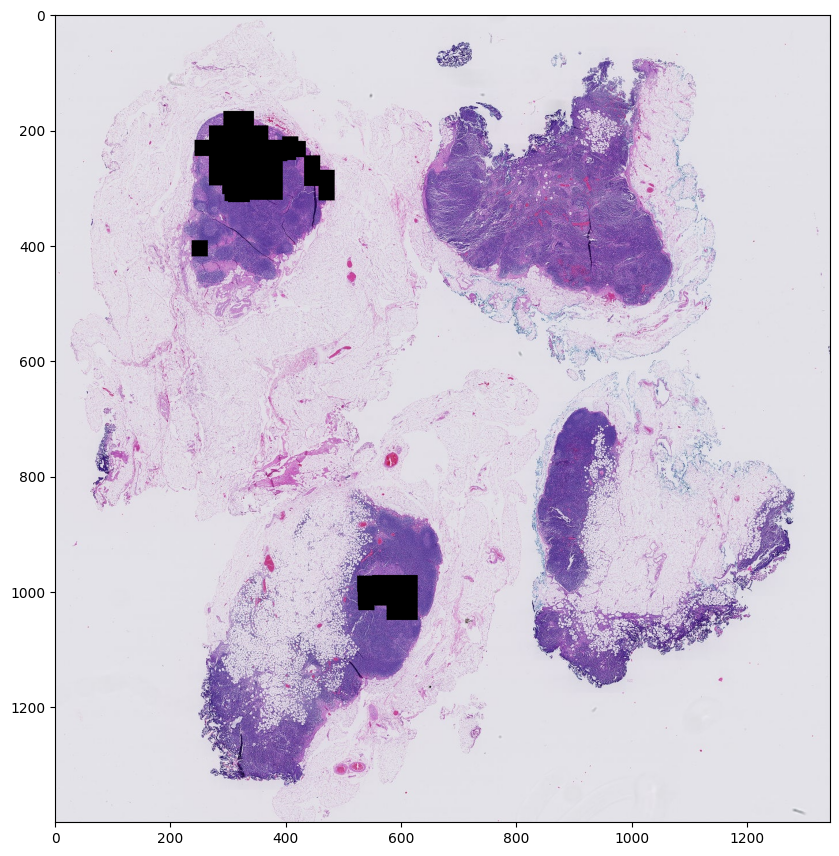

In [423]:
thumbnail = reader.slide_thumbnail(resolution=thumbnail_level, units="level")
thumbnail = np.copy(thumbnail)
for index in tqdm(range(len(tumor_data))):
    img = tumor_data[index]['img']
    patch_info = tumor_data[index]['patch_info']
    coord = patch_info['coordinates']

    x = coord[0]//downsample_factor_y
    y = coord[1]//downsample_factor_x

    slide_size = tumor_data[index]['patch_size']//2**((thumbnail_level-tumor_data[0]['patch_level']))
    thumbnail[y:y+slide_size, x:x+slide_size] = 0
    adjusted_polygon = scale(patch_info['target_polygon'], xfact=1/downsample_factor_x, 
                             yfact=1/downsample_factor_y, origin=(0, 0))
    xx, yy = adjusted_polygon.exterior.xy  
    mpl_polygon = MplPolygon(xy=list(zip(xx, yy)), edgecolor='red', facecolor='none')
    ax.add_patch(mpl_polygon) 

fig, ax = plt.subplots(figsize=(10, 20))  
ax.imshow(thumbnail)



In [424]:
if intersection.geom_type == 'MultiPolygon':
    for geom in intersection.geoms:
        x, y = geom.exterior.xy
        coords = normalize_coords(zip(x, y), start_x, start_y)
        draw.polygon(coords, outline=1, fill=1)
# If it's just a Polygon, no need to iterate
elif intersection.geom_type == 'Polygon':
    x, y = intersection.exterior.xy
    coords = normalize_coords(zip(x, y), start_x, start_y)
    draw.polygon(coords, outline=1, fill=1)

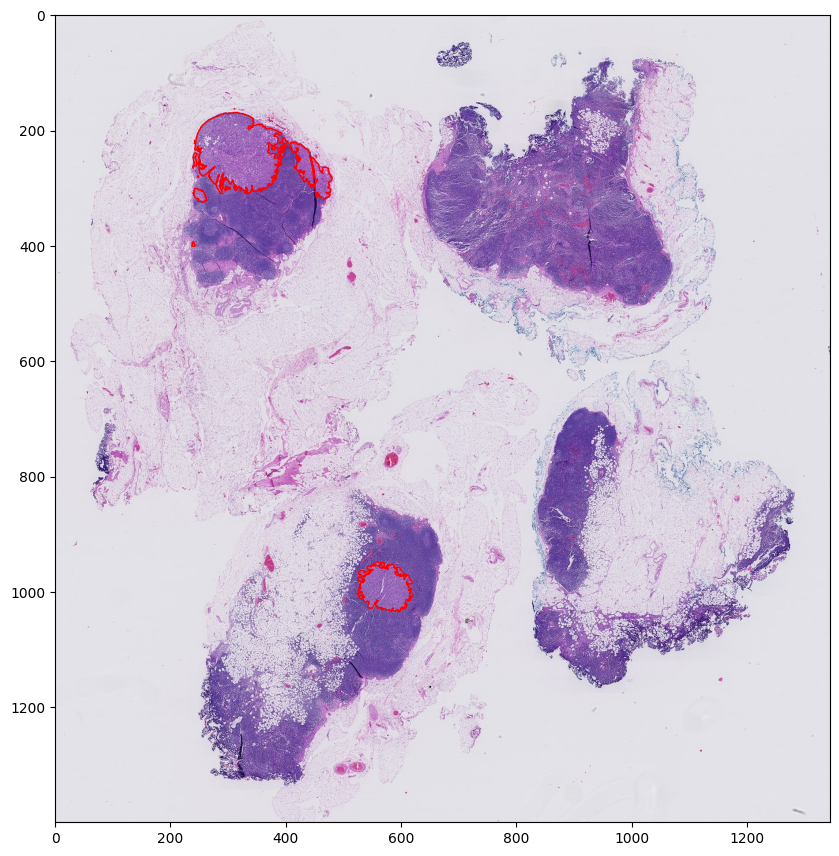

In [425]:
thumbnail_dimensions = info_dict['level_dimensions'][thumbnail_level]
full_res_dimensions = info_dict['slide_dimensions']

downsample_factor_x = full_res_dimensions[0] / thumbnail_dimensions[0]
downsample_factor_y = full_res_dimensions[1] / thumbnail_dimensions[1]
thumbnail = reader.slide_thumbnail(resolution=thumbnail_level, units="level")
fig, ax = plt.subplots(figsize=(10, 20))  
polygons = xml_to_polygons(xml_file_path)

ax.imshow(thumbnail)
for polygon in polygons:
    adjusted_polygon = scale(polygon, xfact=1/downsample_factor_x, yfact=1/downsample_factor_y, origin=(0, 0))
    
    adjusted_polygons = []
    if adjusted_polygon.geom_type == 'MultiPolygon':
        adjusted_polygons = list(adjusted_polygon.geoms)
    elif adjusted_polygon.geom_type == 'Polygon':
        adjusted_polygons.append(adjusted_polygon)

    for adjusted_polygon in adjusted_polygons:
        x, y = adjusted_polygon.exterior.xy  
        mpl_polygon = MplPolygon(xy=list(zip(x, y)), edgecolor='red', facecolor='none')
        ax.add_patch(mpl_polygon) 
# plt.savefig('test.png', dpi=1000)
plt.show()

In [426]:
for i,_ in enumerate(tumor_data):
    if tumor_data[i]['patch_info']['percentage_inside']<100:
        print(i, tumor_data[i]['patch_info']['percentage_inside'])

0 75.20654364204961
6 84.40457166308268
9 66.36968025135
10 70.27061032084762
11 70.36946406250829
12 63.771995286893
14 92.19453122833731
15 96.42856533188818
17 66.22764005856924
18 67.05288336606273
19 76.1688479758855
20 55.739118303571324
24 64.00805107989906
25 53.285504343753864
30 62.3221216541655
35 98.52119033426581
36 98.25399897946242
41 79.54795163818632
44 61.40263999919958
45 67.64477134227184
46 80.41472920893342
47 59.423545692288116
48 71.41263488826122


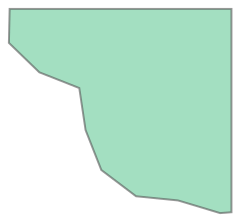

In [433]:
index = 12
intersection = tumor_data[index]['patch_info']['intersection']
intersection

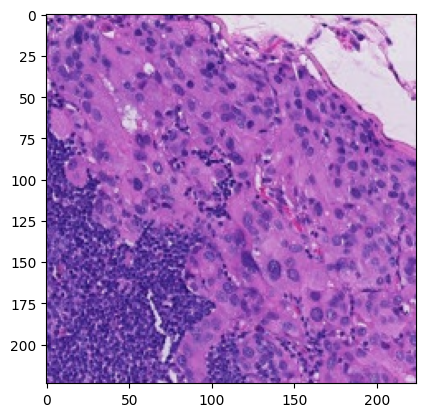

In [435]:
plt.imshow(tumor_data[index]['img'])

In [436]:
from PIL import Image, ImageDraw


In [437]:
def normalize_coords(coords, start_x, start_y):
    return [(x - start_x, y - start_y) for x, y in coords]

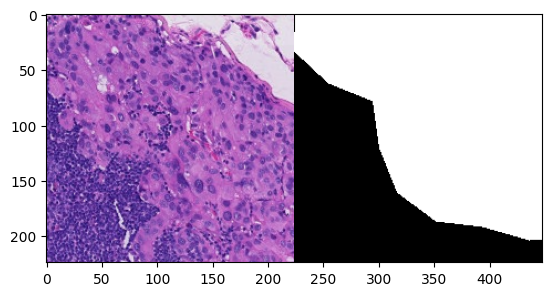

In [439]:
image_size = tumor_data[index]['patch_size']
mask_image = Image.new('L', (image_size, image_size), 0)

# Prepare to draw on the image
draw = ImageDraw.Draw(mask_image)
start_x = tumor_data[index]['patch_info']['coordinates'][0]
start_y = tumor_data[index]['patch_info']['coordinates'][1]
if intersection.geom_type == 'MultiPolygon':
    for geom in intersection.geoms:
        x, y = geom.exterior.xy
        coords = normalize_coords(zip(x, y), start_x, start_y)
        draw.polygon(coords, outline=1, fill=1)
# If it's just a Polygon, no need to iterate
elif intersection.geom_type == 'Polygon':
    x, y = intersection.exterior.xy
    coords = normalize_coords(zip(x, y), start_x, start_y)
    draw.polygon(coords, outline=1, fill=1)
    
mask_array = np.array(mask_image)
# mask_array = np.fliplr(mask_array)
mask_array = np.flipud(mask_array)
mask_array = np.repeat(mask_array[:, :, None], 3, 2)*255

plt.imshow(np.concatenate([tumor_data[index]['img'], mask_array], 1))
plt.show()